In [3]:
import pandas as pd
import numpy as np
import random

In [5]:
path = r"C:\Users\hazem\OneDrive\Documents\archive\assignments\weatherHistory.csv"

df = pd.read_csv(path)

df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [21]:
def temp_to_obs(t):
    if t < 10:
        return 0
    elif t < 20:
        return 1
    else:
        return 2

df["Obs"] = df["Temperature (C)"].apply(temp_to_obs)
O = df["Obs"].values.astype(int)

print("Observation distribution:")
print(pd.Series(O).value_counts().sort_index())

Observation distribution:
0    42436
1    33340
2    20677
Name: count, dtype: int64


In [25]:
# Train / Test split
train_ratio = 0.7
split = int(len(O) * train_ratio)
O_train = O[:split]
O_test = O[split:]  # حاليا مش بنستخدمه، لكن مفيد لو حابب تقيّم على بيانات جديدة

print(f"Train: {len(O_train)}, Test: {len(O_test)}")

Train: 67517, Test: 28936


In [27]:
# ====================== 2. HMM Parameters ======================
N = 3  # Hidden states
M = 3  # Observation symbols (0,1,2)

In [29]:
# ====================== 3. Initialization (Dirichlet) ======================
rng = np.random.default_rng(seed=42)

# Initial state distribution
pi = rng.dirichlet(np.ones(N))

# Transition matrix A (N x N)
A = rng.dirichlet(np.ones(N), size=N)

# Emission matrix B (N x M)
B = rng.dirichlet(np.ones(M), size=N)

In [31]:
# ====================== 4. Scaled Forward Algorithm ======================
def forward_scaled(O, pi, A, B):
    T = len(O)
    alpha = np.zeros((T, N))
    c = np.zeros(T)  # scaling coefficients

    # t = 0
    alpha[0] = pi * B[:, O[0]]
    c[0] = alpha[0].sum()
    if c[0] == 0:
        c[0] = 1e-12
    alpha[0] /= c[0]

    # t = 1..T-1
    for t in range(1, T):
        alpha[t] = (alpha[t - 1] @ A) * B[:, O[t]]
        c[t] = alpha[t].sum()
        if c[t] == 0:
            c[t] = 1e-12
        alpha[t] /= c[t]

    # log P(O | model)
    log_likelihood = np.sum(np.log(c))
    return alpha, c, log_likelihood

In [35]:
# ====================== 5. Scaled Backward Algorithm ======================
def backward_scaled(O, A, B, c):
    T = len(O)
    beta = np.zeros((T, N))

    # Start with scaled value at the last time step
    beta[T - 1] = 1.0 / c[T - 1]

    # t = T-2 .. 0
    for t in range(T - 2, -1, -1):
        beta[t] = A @ (B[:, O[t + 1]] * beta[t + 1])
        beta[t] /= c[t + 1]  # مهم جداً عشان نحافظ على الـ scaling

    return beta


In [37]:
# ====================== 6. Baum-Welch Training ======================
def baum_welch(O, pi_init, A_init, B_init, max_iter=50, tol=1e-5):
    pi = pi_init.copy()
    A = A_init.copy()
    B = B_init.copy()

    loglik_history = []
    T = len(O)

    for it in range(max_iter):
        # ----- E-step -----
        alpha, c, loglik = forward_scaled(O, pi, A, B)
        beta = backward_scaled(O, A, B, c)

        loglik_history.append(loglik)
        print(f"Iteration {it + 1:2d} | Log-Likelihood: {loglik:.2f}")

        # gamma_t(i) = P(q_t = i | O, λ)
        gamma = alpha * beta
        gamma /= gamma.sum(axis=1, keepdims=True)

        # xi_t(i,j) = P(q_t=i, q_{t+1}=j | O, λ)
        xi = np.zeros((T - 1, N, N))
        for t in range(T - 1):
            joint = (
                alpha[t][:, None]
                * A
                * B[:, O[t + 1]][None, :]
                * beta[t + 1][None, :]
            )
            denom = joint.sum()
            if denom == 0:
                denom = 1e-12
            xi[t] = joint / denom

        # ----- M-step -----
        # Update initial distribution
        pi_new = gamma[0]

        # Update transition matrix A
        A_new = xi.sum(axis=0)
        A_new /= A_new.sum(axis=1, keepdims=True)

        # Update emission matrix B
        B_new = np.zeros((N, M))
        for k in range(M):
            mask = (O == k)
            if not np.any(mask):
                continue  # لو مفيش ولا observation بالرمز ده، نسيبه صفر مؤقتاً
            B_new[:, k] = gamma[mask].sum(axis=0)

        # Normalization + حماية من القسمة على صفر
        row_sums = B_new.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1e-12
        B_new /= row_sums

        # Apply updates
        pi, A, B = pi_new, A_new, B_new

        # Convergence check
        if it > 0 and abs(loglik_history[-1] - loglik_history[-2]) < tol:
            print(f"Converged after {it + 1} iterations!")
            break

    return pi, A, B, loglik_history

In [39]:
# ====================== 7. Run Training ======================
# Save initial parameters for comparison
pi_old = pi.copy()
A_old = A.copy()
B_old = B.copy()

alpha_init, c_init, loglik_init = forward_scaled(O_train, pi_old, A_old, B_old)
print(f"\nInitial Train Log-Likelihood: {loglik_init:.2f}")

print("\nStarting Baum-Welch training...\n" + "=" * 50)
pi_new, A_new, B_new, history = baum_welch(O_train, pi, A, B, max_iter=40)



Initial Train Log-Likelihood: -82643.12

Starting Baum-Welch training...
Iteration  1 | Log-Likelihood: -82643.12
Iteration  2 | Log-Likelihood: -63157.34
Iteration  3 | Log-Likelihood: -43626.41
Iteration  4 | Log-Likelihood: -36718.29
Iteration  5 | Log-Likelihood: -35113.27
Iteration  6 | Log-Likelihood: -34860.76
Iteration  7 | Log-Likelihood: -34826.97
Iteration  8 | Log-Likelihood: -34821.82
Iteration  9 | Log-Likelihood: -34820.63
Iteration 10 | Log-Likelihood: -34820.10
Iteration 11 | Log-Likelihood: -34819.72
Iteration 12 | Log-Likelihood: -34819.38
Iteration 13 | Log-Likelihood: -34819.06
Iteration 14 | Log-Likelihood: -34818.76
Iteration 15 | Log-Likelihood: -34818.48
Iteration 16 | Log-Likelihood: -34818.22
Iteration 17 | Log-Likelihood: -34817.97
Iteration 18 | Log-Likelihood: -34817.74
Iteration 19 | Log-Likelihood: -34817.51
Iteration 20 | Log-Likelihood: -34817.30
Iteration 21 | Log-Likelihood: -34817.10
Iteration 22 | Log-Likelihood: -34816.92
Iteration 23 | Log-Likel


TRAINING COMPLETED!

Initial Emission Matrix (B):
         Cold (<10°C)  Mild (10–20°C)  Hot (>20°C)
State 1         0.517           0.115        0.368
State 2         0.274           0.163        0.562
State 3         0.352           0.161        0.487

Final Emission Matrix (B):
         Cold (<10°C)  Mild (10–20°C)  Hot (>20°C)
State 1         0.998           0.002        0.000
State 2         0.003           0.599        0.398
State 3         0.992           0.008        0.000

Initial Transition Matrix (A):
         State 1  State 2  State 3
State 1    0.154    0.048    0.799
State 2    0.306    0.677    0.017
State 3    0.474    0.032    0.494

Final Transition Matrix (A):
         State 1  State 2  State 3
State 1    0.167    0.029    0.803
State 2    0.022    0.976    0.001
State 3    0.479    0.030    0.491

Log-Likelihood Improvement on Train: +47828.54


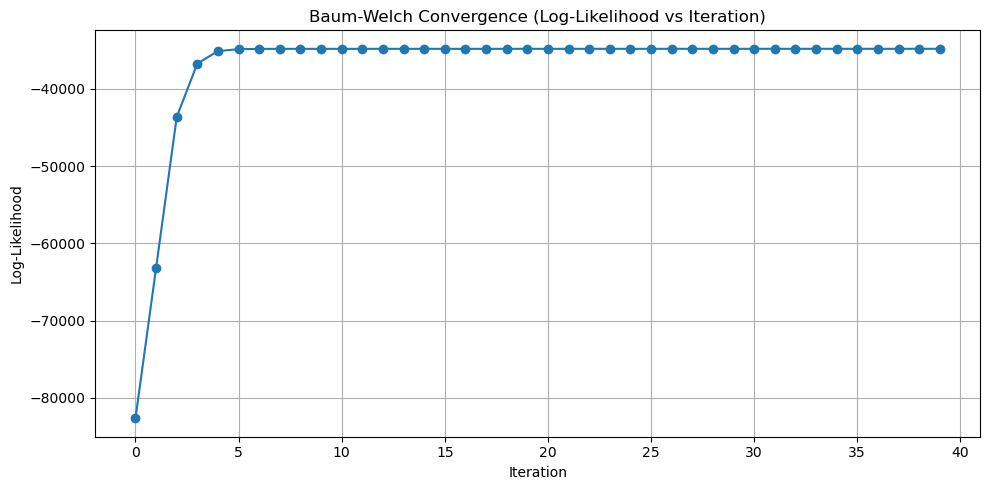


State Interpretation (based on learned emissions):
  • State 1 → Mostly Cold (<10°C) (prob = 0.998)
  • State 2 → Mostly Mild (10–20°C) (prob = 0.599)
  • State 3 → Mostly Cold (<10°C) (prob = 0.992)


In [40]:
# ====================== 8. Final Results & Analysis ======================
print("\n" + "=" * 60)
print("TRAINING COMPLETED!")
print("=" * 60)

obs_names = ["Cold (<10°C)", "Mild (10–20°C)", "Hot (>20°C)"]
state_names = [f"State {i + 1}" for i in range(N)]

print("\nInitial Emission Matrix (B):")
print(pd.DataFrame(B_old, index=state_names, columns=obs_names).round(3))

print("\nFinal Emission Matrix (B):")
print(pd.DataFrame(B_new, index=state_names, columns=obs_names).round(3))

print("\nInitial Transition Matrix (A):")
print(pd.DataFrame(A_old, index=state_names, columns=state_names).round(3))

print("\nFinal Transition Matrix (A):")
print(pd.DataFrame(A_new, index=state_names, columns=state_names).round(3))

final_ll = history[-1]
print(f"\nLog-Likelihood Improvement on Train: {final_ll - loglik_init:+.2f}")

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(history, marker="o")
plt.title("Baum-Welch Convergence (Log-Likelihood vs Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()

# State Interpretation
print("\nState Interpretation (based on learned emissions):")
for i in range(N):
    dominant_obs_idx = np.argmax(B_new[i])
    dominant_obs = obs_names[dominant_obs_idx]
    prob = B_new[i, dominant_obs_idx]
    print(f"  • {state_names[i]} → Mostly {dominant_obs} (prob = {prob:.3f})")